In [13]:
# uses DFCA 4.3


import sys, glob, importlib

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [2]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING) 

In [3]:
sys.path.append("/home/endrit/Documents/Scripts/SSM-V2/python/")
import ssm.tools, ssm.iovtk, ssm.atlas, ssm.initialize_controlpoints

In [4]:
%matplotlib inline

#### Basic parameters

In [5]:
base_dir = "/home/endrit/Documents/Modelling/Post_Repair_COA/SSM/"

In [6]:
#lid = [l.strip() for l in open("list.txt", "r")]

1) first init control points (basic grid)  
2) freeze control points and compute template  
3) then freeze the template and optimise the control points  
4) then freeze control points and recompute template  

# Init control points

In [ ]:
# assumes files are in MILLIMETRES

In [6]:
datadir = "/home/endrit/Documents/Modelling/Post_Repair_COA/SSM/input_surfs_mm/"

In [10]:
# defining params
ae = ssm.atlas.DeformetricaAtlasEstimation(
        idir=datadir,
        odir=base_dir + "r0/",
        name="Aorta",
        initial_guess=base_dir + "initial_guess/mm/initial_guess_final.vtk",
        kwd=20.,
        kwg=15.,
        noise=10.)

# init control points first before setting in params
params = {'convergence_tolerance': 0.01, 'max_iterations': 50,
          'initial_control_points': ae.odir+"initial_controlpoints.txt",
          "freeze_control_points":True, "freeze_template":False}

ae.save_parameters(True)

In [9]:
############ SKIP IF CONTROL POINTS ALREADY INITIALISED ##############
# init control points (var 'margin' assumes in millimetres)

b,p = ssm.initialize_controlpoints.initialize_controlpoints(ae.lf, spacing=ae.p_kernel_width_deformation, margin=1, 
                                                     output_dir=ae.odir, name="initial_controlpoints.txt")
print(p.shape)

ssm.iovtk.controlpoints_to_vtkPoints_files(ae.odir+"initial_controlpoints.txt", ae.odir+"initial_controlpoints.vtk")

(300, 3)


In [11]:
ae.estimate(params)

overwriting parameters:  convergence_tolerance from:  0.001 to:  0.01
overwriting parameters:  max_iterations from:  50 to:  50
overwriting parameters:  initial_control_points from:  None to:  /home/endrit/Documents/Modelling/Post_Repair_COA/SSM/r0/initial_controlpoints.txt
overwriting parameters:  freeze_control_points from:  True to:  True
overwriting parameters:  freeze_template from:  False to:  False
Logger has been set to: DEBUG
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 12
nofile (soft): 1024, nofile (hard): 1048576
>> No specified state-file. By default, Deformetrica state will by saved in file: /home/endrit/Documents/Modelling/Post_Repair_COA/SSM/r0/output/deformetrica-state.p.


/home/endrit/anaconda3/envs/dfca-env-4.3/lib/python3.8/site-packages/deformetrica/core/observations/deformable_objects/landmarks/surface_mesh.py:37: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  triangles_to_keep = torch.nonzero(torch.norm(normals, 2, 1) != 0)


instantiating kernel torch with kernel_width 20.0 and gpu_mode GpuMode.KERNEL. addr: 0x7fe9e52ff820
instantiating kernel torch with kernel_width 15.0 and gpu_mode GpuMode.KERNEL. addr: 0x7fe9e51c3340
>> Reading 300 initial control points from file /home/endrit/Documents/Modelling/Post_Repair_COA/SSM/r0/initial_controlpoints.txt.
>> Momenta initialized to zero, for 67 subjects.
{'memory_length': 1, 'freeze_template': False, 'max_line_search_iterations': 10, 'optimized_log_likelihood': 'complete', 'optimization_method_type': 'scipylbfgs', 'max_iterations': 50, 'convergence_tolerance': 0.01, 'print_every_n_iters': 1, 'save_every_n_iters': 100, 'gpu_mode': <GpuMode.KERNEL: 4>, 'state_file': '/home/endrit/Documents/Modelling/Post_Repair_COA/SSM/r0/output/deformetrica-state.p', 'load_state_file': False}
dtype=float32
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------
>> Log-like

In [14]:
M = ae.read_momenta()
C = ae.read_ctrlpoints()
varM = np.var(M, axis=0).sum(axis=1)

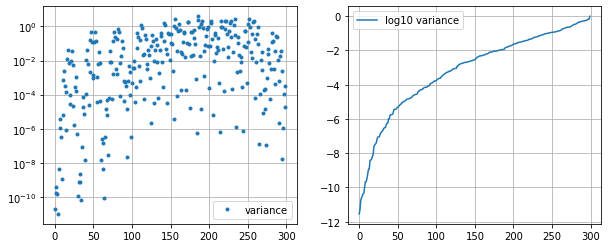

In [15]:
# plot variance vs control points
idx = varM.argsort()

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))

ax0.plot(varM, ".", label="variance")
ax0.semilogy()

ax1.plot((np.log(varM[idx])-np.log(varM.max())) / np.log(10), label="log10 variance")
#ax1.set_xticks([0, 50, 100, 200])
ax0.legend()
ax1.legend()
ax0.grid(True)
ax1.grid(True)

In [16]:
# truncating bad control points
Ncp = int(np.sum(varM < 0.001*varM.max()))

# keep remaining ctrl points
C0 = C[varM > varM[idx][Ncp], :]
print(C0.shape)

(172, 3)


In [17]:
# writing the txt array and vtk point cloud
import deformetrica
deformetrica.in_out.array_readers_and_writers.write_2D_array(C0, ae.odir, "sel_controlpoints.txt")

ssm.iovtk.controlpoints_to_vtkPoints_files(ae.odir + "sel_controlpoints.txt",
                                           ae.odir + "sel_controlpoints.vtk")

In [ ]:
# SECOND ROUND OF ATLAS ESTIMATION

In [20]:
ae = ssm.atlas.DeformetricaAtlasEstimation(
        idir=datadir,
        odir=base_dir + "r1/",
        name="Aorta",
        initial_guess=base_dir + "r0/output/DeterministicAtlas__EstimatedParameters__Template_Aorta.vtk",
        kwd=20.,
        kwg=15.,
        noise=10.)

# freeze template this time, to optimise ctrl points
params = {'convergence_tolerance': 0.001, 'max_iterations': 100,
         "initial_control_points":base_dir + "r0/sel_controlpoints.txt",
          "freeze_control_points":False, "freeze_template":True}

ae.save_parameters(True)

In [21]:
ae.estimate(params)

overwriting parameters:  convergence_tolerance from:  0.001 to:  0.001
overwriting parameters:  max_iterations from:  50 to:  100
overwriting parameters:  initial_control_points from:  None to:  /home/endrit/Documents/Modelling/Post_Repair_COA/SSM/r0/sel_controlpoints.txt
overwriting parameters:  freeze_control_points from:  True to:  False
overwriting parameters:  freeze_template from:  False to:  True
Logger has been set to: DEBUG
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 12
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: /home/endrit/Documents/Modelling/Post_Repair_COA/SSM/r1/output/deformetrica-state.p.
>> Reading 172 initial control points from file /home/endrit/Documents/Modelling/Post_Repair_COA/SSM/r0/sel_controlpoints.txt.
>> Momenta initialized to zero, for 67 subjects.
{'memory_length': 1, 'freeze_template': True, 'max_line_search_iterat

In [22]:
ae.save_controlpoints_vtk()

In [ ]:
# THIRD ROUND OF ATLAS ESTIMATION

In [23]:
ae = ssm.atlas.DeformetricaAtlasEstimation(
        idir=datadir,
        odir=base_dir + "r2/",
        name="Aorta",
        initial_guess=base_dir + "r1/output/DeterministicAtlas__EstimatedParameters__Template_Aorta.vtk",
        kwd=20.,
        kwg=15.,
        noise=5.)

params = {'convergence_tolerance': 0.001,
         "initial_control_points":base_dir + "r1/output/DeterministicAtlas__EstimatedParameters__ControlPoints.txt",
          "freeze_control_points":True, "freeze_template":False}

ae.save_parameters(True)

In [24]:
ae.estimate(params)

overwriting parameters:  convergence_tolerance from:  0.001 to:  0.001
overwriting parameters:  initial_control_points from:  None to:  /home/endrit/Documents/Modelling/Post_Repair_COA/SSM/r1/output/DeterministicAtlas__EstimatedParameters__ControlPoints.txt
overwriting parameters:  freeze_control_points from:  True to:  True
overwriting parameters:  freeze_template from:  False to:  False
Logger has been set to: DEBUG
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 12
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: /home/endrit/Documents/Modelling/Post_Repair_COA/SSM/r2/output/deformetrica-state.p.
>> Reading 172 initial control points from file /home/endrit/Documents/Modelling/Post_Repair_COA/SSM/r1/output/DeterministicAtlas__EstimatedParameters__ControlPoints.txt.
>> Momenta initialized to zero, for 67 subjects.
{'memory_length': 1, 'freeze_template': 

In [ ]:
#### end of new atlas computation